In [1]:
import numpy as np
from torch.utils.data import DataLoader
import torch
from matplotlib import pyplot as plt

### Load dataset

In [2]:
from utils.data_utils import load_config
config = load_config("models/configurations/config.yaml")
config["dataset"]["radar_gt_input"] = True

In [3]:
from utils.w4c_dataloader import RainData

class RadarOnly(RainData):
    def __getitem__(self, idx):
        sat, rad, metadata = super().__getitem__(idx)
        metadata["target"]["mask"] = metadata["target"]["mask"][:, 4:]
        return rad[:, :4], rad[:, 4:], metadata

valid_set = RadarOnly("validation", **config["dataset"])

### Load model

In [ ]:
from models.models import Radar2RadarUNet

model = Radar2RadarUNet.load_from_checkpoint("weights/radar2radar-unet.ckpt")

### Predict

In [5]:
predict_loader = iter(DataLoader(valid_set, batch_size=16, num_workers=0, shuffle=True))

In [6]:
inp, out, _ = next(predict_loader)

In [7]:
with torch.no_grad():
    pred = model(inp)

### Visualize

3


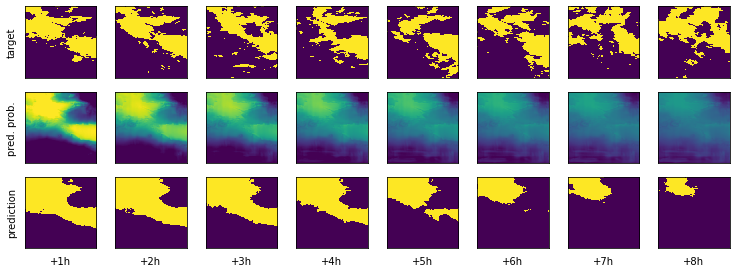

In [14]:
# for sample_index in range(16):
for sample_index in [3]:
    print(sample_index)
    stride = 4
    start = 3
    fig, axs = plt.subplots(3, 32//stride, figsize=(8*1.3, 3*1.3))

    for t in range(start, 32, stride):
        axs[0, t//stride].imshow(out[sample_index, 0, t], vmin=0, vmax=1, interpolation="none")
        axs[1, t//stride].imshow(torch.sigmoid(pred[sample_index, 0, t]), vmin=0.1, vmax=0.9, interpolation="none")
        axs[2, t//stride].imshow(pred[sample_index, 0, t] > 0, vmin=0, vmax=1, interpolation="none")

    for ax in axs.ravel(): ax.set_xticks([])
    for ax in axs.ravel(): ax.set_yticks([])
    plt.setp(axs[0, 0], ylabel='target')
    plt.setp(axs[1, 0], ylabel='pred. prob.')
    plt.setp(axs[2, 0], ylabel='prediction')

    for t in range(start, 32, stride):
        plt.setp(axs[-1, t//stride], xlabel=f"+{(t+1)//4}h")

    plt.tight_layout()
    plt.savefig("plots/outputs-radar2radar.pdf")
    plt.show()